## Introdução
Existem muitos modelos sofisticados que as pessoas podem construir para resolver um problema de previsão. No entanto, eles costumam se limitar a modelos simples do Excel com base em valores históricos médios, intuição e algumas heurísticas específicas de domínio de alto nível. Essa abordagem pode ser precisa o suficiente para o problema em questão, mas existem alternativas que podem adicionar mais informações à previsão com uma quantidade razoável de esforço adicional.

Uma abordagem que pode produzir uma melhor compreensão da gama de resultados potenciais e ajudar a evitar a “ falha das médias ” é uma simulação de Monte Carlo . O restante deste artigo descreverá como usar python com pandas e numpy para construir uma simulação de Monte Carlo para prever a faixa de valores potenciais para um orçamento de compensação de vendas. 

### Histórico do problema
Para este exemplo, tentaremos prever quanto dinheiro devemos orçar para as comissões de vendas para o próximo ano. Este problema é útil para modelagem porque temos uma fórmula definida para calcular as comissões e provavelmente temos alguma experiência com o pagamento de comissões de anos anteriores.

Esse problema também é importante do ponto de vista de negócios. As comissões de vendas podem ser uma grande despesa de vendas e é importante planejar adequadamente para essas despesas. Além disso, o uso de uma simulação de Monte Carlo é uma melhoria relativamente simples que pode ser feita para aumentar o que normalmente é um processo de estimativa não sofisticado.

Neste exemplo, a comissão de vendas de amostra seria assim para uma equipe de vendas de 5 pessoas:

|Vendedor|Meta de Vendas|Vendas Atual|Vendas Atual(%)|Taxa de comissão|montante de comissão|
|:------:|:------------:|:----------:|:-------------:|:--------------:|:------------------:|
|1       |R$ 100.000   |R\$ 88.000  |88,0%          |2%              |R\$ 1.760           |
|2       |R\$ 200.000   |R\$ 202.000 |88,0%          |4%              |R\$ 8.080           |
|3       |R\$ 75.000    |R\$ 90.000  |120,0%         |4%              |R\$ 3.600           |
|4       |R\$ 400.000   |R\$ 360.000 |90,0%          |0               |R\$ 0               |
|5       |R\$ 500.000   |R\$ 350.000 |70,0%          |0               |R\$ 0               |
|total   |R\$ 1.275.000 |R\$ 1.090.000|              |                |R\$ 13.440          |


Neste exemplo, a comissão é o resultado desta fórmula:

**Valor da comissão = Vendas reais * Taxa de comissão**

A taxa de comissão é baseada nesta tabela de porcentagem para o plano:

|Taxa de|comissão|
|:-----:|:------:|
|0 - 90%| 2%     |
|91-99% |3%      |
|>= 100%|4%      |

ntes de construir um modelo e executar a simulação, vamos dar uma olhada em uma abordagem simples para prever as despesas de comissão do próximo ano.

### Abordagem ingênua para o problema
Imagine que sua tarefa como analista é dizer ao setor financeiro quanto deve ser orçado para as comissões de vendas para o próximo ano. Uma abordagem pode ser presumir que todos atingem 100% de sua meta e ganham a taxa de comissão de 4%. Conectar esses valores ao Excel resulta em:

|Vendedor|Meta de Vendas|Vendas Atual|Vendas Atual(%)|Taxa de comissão|montante de comissão|
|:------:|:------------:|:----------:|:-------------:|:--------------:|:------------------:|
|1       |R\$ 100.000   |R\$ 100.000 |100,0%         |4%              |R\$ 4.000           |
|2       |R\$ 200.000   |R\$ 200.000 |100,0%         |4%              |R\$ 8.000           |
|3       |R\$ 75.000    |R\$ 75.000  |100,0%         |4%              |R\$ 3.000           |
|4       |R\$ 400.000   |R\$ 400.000 |100,0%         |4%              |R\$ 16.000          |
|5       |R\$ 500.000   |R\$ 500.000 |100,0%         |4%              |R\$ 20.000          |
|total   |R\$ 1.275.000 |R\$ 1.275.000|              |                |R\$ 51.000          |

Imagine que você apresente isso para o departamento de finanças e eles digam: “Nunca recebemos a mesma taxa de comissão para todos. Precisamos de um modelo mais preciso. ”

Para a segunda rodada, você pode tentar alguns intervalos:

|Vendedor|Meta de Vendas|Vendas Atual|Vendas Atual(%)|Taxa de comissão|montante de comissão|
|:------:|:------------:|:----------:|:-------------:|:--------------:|:------------------:|
|1       |R\$ 100.000   |R\$ 105.000 |105,0%         |4%              |R\$ 4.200           |
|2       |R\$ 200.000   |R\$ 140.000 |70,0%          |2%              |R\$ 2.800           |
|3       |R\$ 75.000    |R\$ 74.250  |99,0%          |3%              |R\$ 2.228           |
|4       |R\$ 400.000   |R\$ 352.000 |88,0%          |2%              |R\$ 7.040           |
|5       |R\$ 500.000   |R\$ 550.000 |110,0%         |4%              |R\$ 22.000          |
|total   |R\$ 1.275.000 |R\$ 1.275.000|              |                |R\$ 38.268          |

Ou outro:

|Vendedor|Meta de Vendas|Vendas Atual|Vendas Atual(%)|Taxa de comissão|montante de comissão|
|:------:|:------------:|:----------:|:-------------:|:--------------:|:------------------:|
|1       |R\$ 100.000   |R\$ 95.000  |95,0%          |3%              |R\$ 2.850           |
|2       |R\$ 200.000   |R\$ 204.000 |102,0%         |4%              |R\$ 8.160           |
|3       |R\$ 75.000    |R\$ 60.000  |80,0%          |2%              |R\$ 1.200           |
|4       |R\$ 400.000   |R\$ 480.000 |120,0%         |4%              |R\$ 19.200          |
|5       |R\$ 500.000   |R\$ 400.000 |80,0%          |2%              |R\$ 8.000           |
|total   |R\$ 1.275.000 |R\$ 1.275.000|              |                |R\$ 39.410          |

gora, você tem um pouco mais de informação e volte para finanças. Desta vez, o departamento de finanças diz: “este intervalo é útil, mas qual é a sua confiança neste intervalo? Além disso, precisamos que você faça isso para uma força de vendas de 500 pessoas e modele várias taxas diferentes para determinar o valor do orçamento. 

Esta abordagem simples ilustra o método iterativo básico para uma simulação de Monte Carlo. Você itera esse processo muitas vezes para determinar uma faixa de valores de comissão em potencial para o ano. 

### Monte carlo
Agora que cobrimos o problema em alto nível, podemos discutir como a análise de Monte Carlo pode ser uma ferramenta útil para prever despesas de comissões para o próximo ano. Em seu nível mais simples, uma análise de Monte Carlo (ou simulação) envolve a execução de muitos cenários com diferentes entradas aleatórias e o resumo da distribuição dos resultados.

Usando a análise de comissões, podemos continuar o processo manual que iniciamos acima, mas executar o programa 100 ou mesmo 1000 vezes e obteremos uma distribuição dos valores potenciais de comissão. Essa distribuição pode informar a probabilidade de a despesa ficar dentro de uma determinada janela. No final do dia, essa é uma previsão, então provavelmente nunca iremos fazer uma previsão exata. Podemos desenvolver uma ideia mais informada sobre o risco potencial de orçamento insuficiente ou excessivo.

Existem dois componentes para executar uma simulação de Monte Carlo:

1. a equação para avaliar
1. as variáveis ​​aleatórias para a entrada

Já descrevemos a equação acima. Agora precisamos pensar sobre como preencher as variáveis ​​aleatórias. Uma suposição razoável é que o percentual de vendas tem distribuição normal com média de 100% e desvio padrão de 10% (para dados reais é aconselhado calcular a média e desvio padrão).

### Construindo um modelo Python
Podemos usar o pandas para construir um modelo que replique o cálculo da planilha do Excel. Existem outras abordagens do python para construir modelos de Monte Carlo, mas acho que esse método do pandas é conceitualmente mais fácil de compreender se você tiver experiência com o Excel. Ele também tem o benefício adicional de gerar dataframes do pandas que podem ser inspecionados e revisados ​​quanto à sua razoabilidade.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')

Para este modelo, usaremos uma geração de número aleatório de numpy. O aspecto útil do numpy é que existem vários geradores de números aleatórios que podem criar amostras aleatórias com base em uma distribuição predefinida.

Conforme descrito acima, sabemos que nosso percentual histórico para atingir o desempenho está centrado em uma média de 100% e desvio padrão de 10%. Vamos definir essas variáveis, bem como o número de representantes de vendas e simulações que estamos modelando:



In [3]:
média  =  1 
std_dev  =  .1 
num_reps  =  500 
num_simulações  =  1000

gora podemos usar numpy para gerar uma lista de porcentagens que replicarão nossa distribuição normal histórica:

In [6]:
pct_de_vendas = np.random.normal(média, std_dev, num_reps).round(2)
pct_de_vendas[:10]

array([0.95, 1.06, 1.01, 0.95, 0.99, 1.01, 1.13, 1.1 , 0.98, 1.04])

Aqui está a aparência dos primeiros 10 itens.

Text(0.5, 1.0, 'distribuição da porcentagem de vendas')

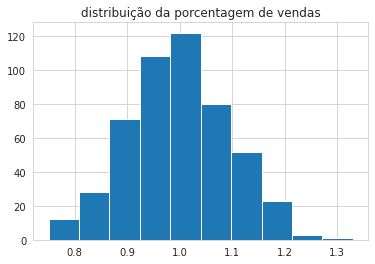

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(pct_de_vendas)
plt.title('distribuição da porcentagem de vendas')

Há um outro valor que precisamos simular e é a meta real de vendas. Para ilustrar uma distribuição diferente, vamos supor que nossa distribuição de meta de vendas seja definida em 1 de 6 intervalos e a frequência fica mais baixa à medida que o valor aumenta. Essa distribuição pode ser indicativa de um processo de definição de metas muito simples, em que os indivíduos são agrupados em determinados grupos e recebem metas consistentemente com base em sua posse, tamanho do território ou pipeline de vendas.

Por causa deste exemplo, usaremos uma distribuição uniforme, mas atribuiremos taxas de probabilidade mais baixas para alguns dos valores.

Aqui está como podemos construir isso usando numpy.random.choice

Text(0.5, 1.0, 'distribuição da meta de vendas')

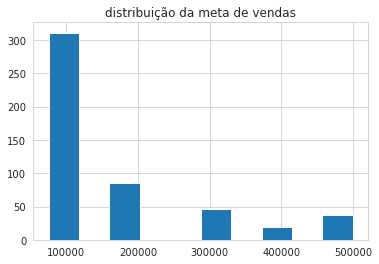

In [13]:
meta_de_vendas_val = [75_000, 100_000, 200_000, 300_000, 400_000, 500_000]
meta_de_vendas_prob = [.3, .3, .2, .1, .05, .05]
meta_de_vendas = np.random.choice(meta_de_vendas_val, num_reps, p=meta_de_vendas_prob)

plt.hist(meta_de_vendas)
plt.title('distribuição da meta de vendas')

Agora que sabemos como criar nossas duas distribuições de entrada, vamos construir um dataframe do pandas:

In [14]:
df = pd.DataFrame(index=range(num_reps), data={'Pct de vendas': pct_de_vendas,
                                               'meta de vendas': meta_de_vendas})

df['vendas'] = df['Pct de vendas'] * df['meta de vendas']
df.head()

,Pct de vendas,meta de vendas,vendas
0,0.95,100000,95000.0
1,1.06,100000,106000.0
2,1.01,100000,101000.0
3,0.95,75000,71250.0
4,0.99,75000,74250.0


Você pode notar que fiz um pequeno truque para calcular o valor real das vendas. Para esse problema, o valor real das vendas pode mudar muito com o passar dos anos, mas a distribuição do desempenho permanece incrivelmente consistente. Portanto, estou usando as distribuições aleatórias para gerar minhas entradas e apoiar as vendas reais.

NA parte final precisamos criar é uma maneira de mapear nossa Pct. de vendas para a  taxa de comissão. Aqui está a função:

In [15]:
def calc_taxa_comissao(x):
    """ Retorna a taxa de comissão baseada na tabela:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    if x <= .90:
        return .02
    if x <= .99:
        return .03
    else:
        return .04

O benefício adicional de usar python em vez de Excel é que podemos criar uma lógica muito mais complexa que é mais fácil de entender do que se tentássemos construir uma instrução if aninhada complexa no Excel.

Agora criamos nossa taxa de comissão e a multiplicamos pelas vendas:

In [17]:
df['taxa de comissão'] = df['Pct de vendas'].apply(calc_taxa_comissao)
df['montante de comissão'] = df['taxa de comissão'] * df['vendas']
df.head()

,Pct de vendas,meta de vendas,vendas,taxa de comissão,montante de comissão
0,0.95,100000,95000.0,0.03,2850.0
1,1.06,100000,106000.0,0.04,4240.0
2,1.01,100000,101000.0,0.04,4040.0
3,0.95,75000,71250.0,0.03,2137.5
4,0.99,75000,74250.0,0.03,2227.5


Aí está!

Nós replicamos um modelo semelhante ao que teríamos feito no Excel, mas usamos algumas distribuições mais sofisticadas do que apenas jogar um monte de entradas de números aleatórios no problema.

### Vamos fazer loop
A verdadeira “mágica” da simulação de Monte Carlo é que, se executarmos uma simulação muitas vezes, começaremos a desenvolver uma imagem da provável distribuição dos resultados. No Excel, você precisaria do VBA ou outro plug-in para executar várias iterações. Em python, podemos usar um for loop para executar quantas simulações quisermos.

Além de executar cada simulação, salvamos os resultados de nosso interesse em uma lista que transformaremos em um dataframe para análise posterior da distribuição dos resultados.

Aqui está o código de loop for completo:


In [18]:
# Defina uma lista para manter todos os resultados de cada simulação que queremos analisar 
resultados = []

# Loop através de muitas simulações 
for i in range(num_simulações):

    # Escolha entradas aleatórias para as metas de vendas e porcentagem para a meta 
    meta_de_vendas = np.random.choice(meta_de_vendas_val, num_reps, p=meta_de_vendas_prob)
    pct_de_vendas = np.random.normal(média, std_dev, num_reps).round(2)

    # Construa o dataframe com base nas entradas e no número de repetições 
    df = pd.DataFrame(index=range(num_reps), data={'Pct de vendas': pct_de_vendas,
                                               'meta de vendas': meta_de_vendas})

    # Voltar para o número de vendas usando a porcentagem da taxa alvo 
    df['vendas'] = df['Pct de vendas'] * df['meta de vendas']

    # Determine a taxa de comissões
    df['taxa de comissão'] = df['Pct de vendas'].apply(calc_taxa_comissao)
    df['montante de comissão'] = df['taxa de comissão'] * df['vendas']

    # Queremos rastrear vendas, valores de comissão e metas de vendas em todas as simulações 
    resultados.append([df['vendas'].sum().round(0),
                      df['montante de comissão'].sum().round(0),
                      df['meta de vendas'].sum().round(0)])

Embora isso possa parecer um pouco intimidante no início, estamos incluindo apenas 7 instruções python dentro desse loop que podemos executar quantas vezes quisermos. Em algum ponto, há retornos decrescentes. Os resultados de 1 milhão de simulações não são necessariamente mais úteis do que 10.000. Meu conselho é tentar diferentes quantidades e ver como a saída muda.

Para analisar os resultados da simulação, irei construir um dataframe:

In [19]:
resultados_df = pd.DataFrame.from_records(resultados, columns=['vendas',
                                                           'montante de comissão',
                                                           'meta de vendas'])
resultados_df.describe().style.format('{:,}')

,vendas,montante de comissão,meta de vendas
count,"1,000.0","1,000.0","1,000.0"
mean,"83,824,728.5","2,862,557.271","83,830,075.0"
std,"2,629,769.3381615262","99,625.16872491114","2,612,853.9233948765"
min,"75,975,250.0","2,566,462.0","75,775,000.0"
25%,"82,128,250.0","2,795,669.5","82,075,000.0"
50%,"83,930,750.0","2,864,150.0","83,900,000.0"
75%,"85,633,125.0","2,927,217.5","85,625,000.0"
max,"92,307,500.0","3,276,472.0","91,600,000.0"


Graficamente, é assim:

In [21]:
# Função da documentação do matplotlib para formatar números na casa dos milhões
def millions(x, pos):
    """The two args are the value and tick position."""
    return 'R${:1.1f}M'.format(x*1e-6)

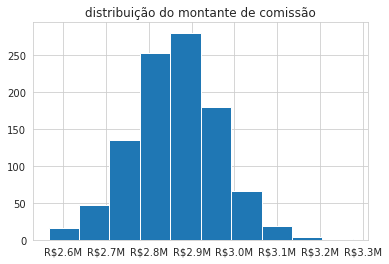

In [23]:
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(millions)
ax.hist(resultados_df['montante de comissão'])
ax.set(title='distribuição do montante de comissão')
plt.show()

Então, o que este gráfico e a saída de describe nos dizem? Podemos ver que a despesa média com comissões é de 2,85 milhões e o desvio padrão é de 103.000. Também podemos ver que o pagamento de comissões pode ser tão baixo quanto  2,5 milhões ou tão alto quanto 3,2 milhões.

Com base nesses resultados, você se sente confortável com o fato de que as despesas com comissões serão inferiores a 3 milhões? Ou, se alguém disser: “Vamos fazer um orçamento de apenas 2,7 milhões”, você se sentiria confortável com o fato de que suas despesas ficariam abaixo desse valor? Provavelmente não.

É aí que está um dos benefícios da simulação de Monte Carlo. Você desenvolve uma melhor compreensão da distribuição dos resultados prováveis ​​e pode usar esse conhecimento, além de sua perspicácia de negócios para fazer uma estimativa informada.

O outro valor desse modelo é que você pode modelar muitas suposições diferentes e ver o que acontece. Aqui estão algumas mudanças simples que você pode fazer para ver como os resultados mudam:

* Aumente a taxa de comissão superior para 5%
* Diminuir o número de vendedores
* Altere o desvio padrão esperado para um valor maior
* Modifique a distribuição de alvos

Outra observação sobre as simulações de Monte Carlo é que elas são relativamente fáceis de explicar ao usuário final da previsão. A pessoa que recebe essa estimativa pode não ter uma formação matemática profunda, mas pode compreender intuitivamente o que esta simulação está fazendo e como avaliar a probabilidade da gama de resultados potenciais.